# Examples on how to use `carculator`

Github: https://github.com/romainsacchi/carculator/

Publication:

*carculator: an open-source tool for prospective environmental and economic life cycle assessment of vehicles. When, Where and How can battery-electric vehicles help reduce greenhouse gas emissions?*

Romain Sacchi, Christian Bauer, Brian Cox, Christopher Mutel

Submitted to Renewable and Sustainable Energy Reviews (*in review*)

# Car model

Import the library

In [1]:
from carculator import *
import matplotlib.pyplot as plt

Load the default car parameters

In [2]:
cip = CarInputParameters()

Define the calculation mode: static or stochastic(number of iterations)
* `static`: the model use one value for each parameter: the most likely value
* `stochastic`: the model uses a range of values pseudo-randomly generated on the basis of a probability distribution. The number of values generated is given by the integer argument passed to `.stochastic()`

In [3]:
cip.static()

Fill-in the array that will be used to create the car models

In [4]:
dcts, array = fill_xarray_from_input_parameters(cip)

We can check the powertrains, sizes and yaers considered

In [5]:
list(array.powertrain.values)

['BEV',
 'FCEV',
 'HEV-d',
 'HEV-p',
 'ICEV-d',
 'ICEV-g',
 'ICEV-p',
 'PHEV-c-d',
 'PHEV-c-p',
 'PHEV-d',
 'PHEV-e',
 'PHEV-p']

2000, 2010, 2017 and 2040 are the default years

In [6]:
list(array.year.values)

[2000, 2010, 2017, 2040]

It is possible to narrow down the scope if you are interested only in a few specific vehicles.
For example here, let's narrow it down to small and medium BEV and ICEV-ds.

In [12]:
scope = {
    "powertrain":["BEV", "ICEV-d"],
    "size":["Small", "Medium"]
}
dcts, array = fill_xarray_from_input_parameters(cip, scope=scope)
list(array.powertrain.values)

['BEV', 'ICEV-d']

It is possible to derive car models for other years by interpolating between 2017 and 2040 (or extrapolating beyond 2040 or before 2017). It is not advised to extrapolate beyond 2050 though.

In [13]:
array = array.interp(year=[2018, 2022, 2035, 2040, 2045, 2050],  kwargs={'fill_value': 'extrapolate'})

We can create now the car models, using the default parameters, while specifying a driving cycle

In [14]:
cm = CarModel(array, cycle='WLTC')

In [15]:
cm.set_all()

In [16]:
[p for p in cm.array.coords["parameter"].values if "engine efficiency" in p]

['engine efficiency']

Let's print the engine efficiency of the medium size diesel vehicle.

In [18]:
cm.array.sel(powertrain="ICEV-d", year=2035, size="Medium", parameter="engine efficiency")

<xarray.DataArray (value: 1)>
array([0.32130435])
Coordinates:
    size        <U6 'Medium'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'engine efficiency'
  * value       (value) int32 0
    year        int32 2035

Alternatively, we can override specific parameters value, by passing a dictionary or a filepath to an Excel file.
For example, we can to lower the lifetime (expressed in kilometers) of the vehicles:

In [19]:
dict_param = {('Driving', 'all', 'all', 'lifetime kilometers', 'none'): {(2018, 'loc'): 150000, (2040, 'loc'): 150000}}

modify_xarray_from_custom_parameters(dict_param, array)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

Let's now check the new lifetime value for the medium size diesel car.

In [20]:
cm.array.sel(powertrain='ICEV-d', size='Medium', value=0, parameter='lifetime kilometers')

<xarray.DataArray (year: 6)>
array([150000., 200000., 200000., 150000., 200000., 200000.])
Coordinates:
    size        <U6 'Medium'
    powertrain  <U6 'ICEV-d'
    parameter   <U48 'lifetime kilometers'
    value       int32 0
  * year        (year) int32 2018 2022 2035 2040 2045 2050

Let's look at the Tank-to-wheel energy, for a small electric car

In [21]:
cm.array.sel(powertrain='BEV', size='Small', value=0, parameter='TtW energy')

<xarray.DataArray (year: 6)>
array([664.9105835 , 641.24841309, 568.24963379, 541.70404053,
       515.99890137, 491.09005737])
Coordinates:
    size        <U6 'Small'
    powertrain  <U6 'BEV'
    parameter   <U48 'TtW energy'
    value       int32 0
  * year        (year) int32 2018 2022 2035 2040 2045 2050

Or we indicate a filepath to the Excel file that contains customized values

In [22]:
dcts, array = fill_xarray_from_input_parameters(cip)
fp = r'C:\Users\sacchi_r\Downloads\template_workbook.xlsx'
modify_xarray_from_custom_parameters(fp, array)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

FCEV, ICEV-g, ICEV-p is not a recognized powertrain. It will be skipped.
SUV, Van is not a recognized size category. It will be skipped.
SUV, Van is not a recognized size category. It will be skipped.


One can print the list of input and calculated parameters

In [23]:
cip.parameters

['Acetaldehyde direct emissions, rural',
 'Acetaldehyde direct emissions, suburban',
 'Acetaldehyde direct emissions, urban',
 'Ammonia direct emissions, rural',
 'Ammonia direct emissions, suburban',
 'Ammonia direct emissions, urban',
 'Benzene direct emissions, rural',
 'Benzene direct emissions, suburban',
 'Benzene direct emissions, urban',
 'CNG pump-to-tank leakage',
 'CNG tank mass intercept',
 'CNG tank mass slope',
 'CO2 per kg fuel',
 'Carbon monoxide direct emissions, rural',
 'Carbon monoxide direct emissions, suburban',
 'Carbon monoxide direct emissions, urban',
 'Dinitrogen oxide direct emissions, rural',
 'Dinitrogen oxide direct emissions, suburban',
 'Dinitrogen oxide direct emissions, urban',
 'Formaldehyde direct emissions, rural',
 'Formaldehyde direct emissions, suburban',
 'Formaldehyde direct emissions, urban',
 'H2 tank mass per energy',
 'Hydrocarbons direct emissions, rural',
 'Hydrocarbons direct emissions, suburban',
 'Hydrocarbons direct emissions, urban'

We can also override calculated parameters. For example, the driving mass:

In [27]:
cm.array.loc['Small','BEV','driving mass',:] = [[2000],[2200],[2200],[2200]]

In [28]:
cm.array.sel(powertrain="BEV", size="Small", value=0, parameter="driving mass")

<xarray.DataArray (year: 4)>
array([2000., 2200., 2200., 2200.])
Coordinates:
    size        <U12 'Small'
    powertrain  <U8 'BEV'
    parameter   <U48 'driving mass'
  * year        (year) int32 2000 2010 2017 2040
    value       int32 0

In [29]:
cm = CarModel(array, cycle='WLTC')
cm.set_ttw_efficiency()
cm.calculate_ttw_energy()

We can now see that the Tank to wheel parameter value is different since we increased the driving mass of the vehicle.

In [30]:
cm.array.sel(powertrain='BEV', size='Small', value=0, parameter='TtW energy')

<xarray.DataArray (year: 4)>
array([1088.28942871, 1047.92126465,  867.25909424,  742.20233154])
Coordinates:
    size        <U12 'Small'
    powertrain  <U8 'BEV'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2000 2010 2017 2040
    value       int32 0

## Driving cycles

### Standard driving cycles

We can also change the driving cycle, among those offered:
* WLTC
* WLTC 3.1
* WLTC 3.2
* WLTC 3.3
* WLTC 3.4
* CADC Urban
* CADC Road
* CADC Motorway
* CADC Motorway 130
* CADC
* NEDC

In [31]:
cm = CarModel(array, cycle='CADC')
cm.set_all()
cm.array.sel(powertrain='ICEV-d', size='Medium', value=0, parameter='TtW energy')

<xarray.DataArray (year: 4)>
array([3471.58203125, 2930.55761719, 2823.890625  , 2044.92199707])
Coordinates:
    size        <U12 'Medium'
    powertrain  <U8 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2000 2010 2017 2040
    value       int32 0

### User-provided driving cycles

Or even add our own driving cycle. Let's make a random one.

Text(0.5, 0, 'second of driving')

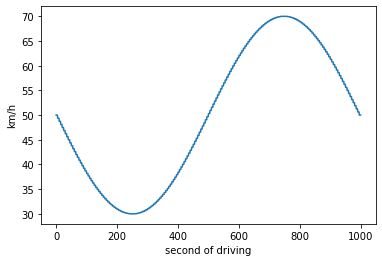

In [32]:
import numpy as np
import matplotlib.pyplot as plt
x = np.linspace(-np.pi, np.pi, 200)
cycle = np.sin(x)*20 + 50
cycle = np.repeat(cycle, 5)
plt.plot(np.arange(0,1000), cycle)

plt.ylabel('km/h')
plt.xlabel('second of driving')

And then pass it to `CarModel` and recalcualte the tank-to-wheel energy.

In [33]:
cm = CarModel(array, cycle=cycle)
cm.set_all()
cm.array.sel(powertrain='ICEV-d', size='Medium', value=0, parameter='TtW energy')

<xarray.DataArray (year: 4)>
array([1553.41223145, 1319.31970215, 1271.14819336,  899.31707764])
Coordinates:
    size        <U12 'Medium'
    powertrain  <U8 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2000 2010 2017 2040
    value       int32 0

### Road gradients

We can add road gradients during a driving cycle. For example, let's say the road is going up by 4% for the first half, and down by 2% for the second half.

In [34]:
velocity = (cycle * 1000) / 3600 # go from km/h to m/s

x = np.array([.04,-.02])
z = np.repeat(x, (velocity.shape[0]/2))
# We have our z vectorm which has the same size as the driving cycle we previously made up.
z.shape

(1000,)

We get the following elevation profile. Teh car ends up more or less at the same altitude it started at.

Text(0.5, 0, 's')

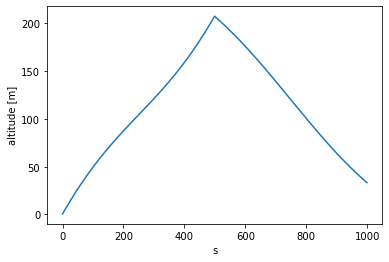

In [35]:
altitude = velocity * z
plt.plot(altitude.cumsum())
plt.ylabel("altitude [m]")
plt.xlabel("s")

We can pass this gradient vector to `CarModel` and recalculate the tank-to-wheel energy.

In [36]:
cm = CarModel(array, cycle=cycle, gradient=z)
cm.set_all()
cm.array.sel(powertrain='ICEV-d', size='Medium', value=0, parameter='TtW energy')

<xarray.DataArray (year: 4)>
array([1952.8840332 , 1652.59692383, 1590.71057129, 1164.00366211])
Coordinates:
    size        <U12 'Medium'
    powertrain  <U8 'ICEV-d'
    parameter   <U48 'TtW energy'
  * year        (year) int32 2000 2010 2017 2040
    value       int32 0

We can plot any attributes of the car models. For example here, the tank to wheel energy of all electric cars in 2018.

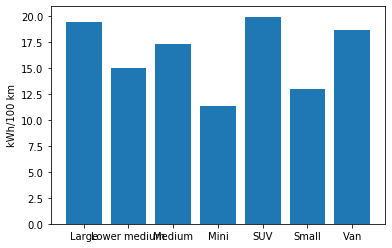

In [37]:
TtW_energy = cm.array.sel(powertrain='BEV', year=2017, parameter='TtW energy', value=0) * 1/3600 * 100
labels = cm.array.coords["size"].values.tolist()

plt.bar(labels, TtW_energy)
plt.ylabel('kWh/100 km')
plt.show()

Or plot the energy consumption second by second

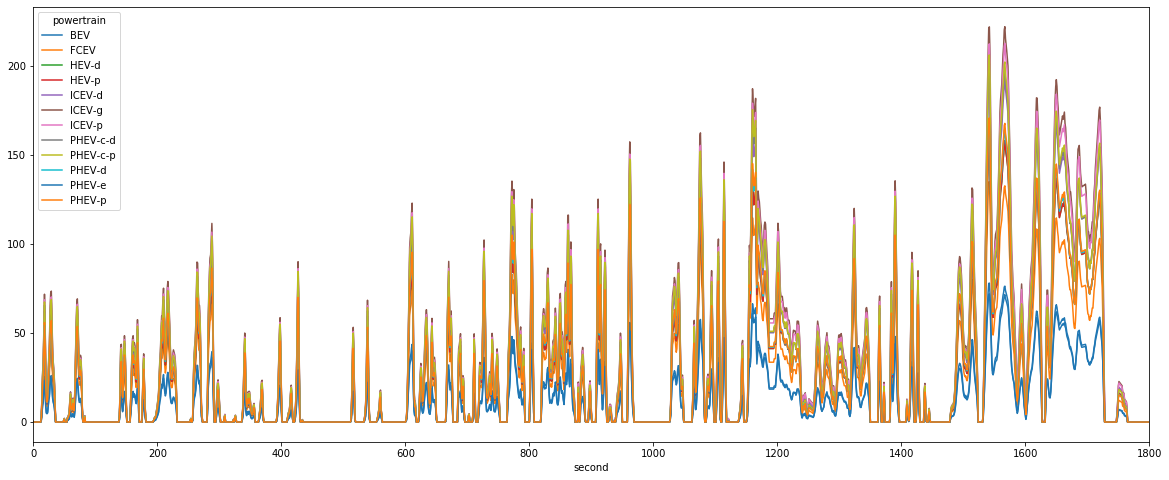

In [38]:
cm = CarModel(array, cycle="WLTC")
cm.set_all()

cm.energy.sel(parameter="motive energy", year=2017, size="Medium", value=0).to_dataframe("val")\
    .unstack()["val"].T.plot(figsize=(20, 8))

The same can be done considering uncertainties in input parameters

In [43]:
cip = CarInputParameters()
# 5000 iterations
cip.stochastic(5000)
dcts, array = fill_xarray_from_input_parameters(cip, scope={"powertrain":["ICEV-d", "BEV"], "size":["Large"], "year":[2017]})
cm = CarModel(array, cycle='WLTC')
cm.set_all()


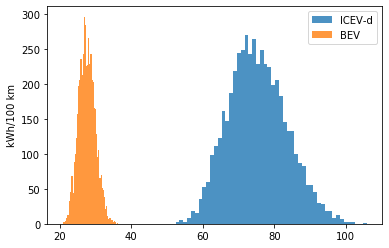

In [44]:
TtW_energy = cm.array.sel(size='Large', year=2017, parameter='TtW energy') * 1/3600 * 100

l_powertrains = TtW_energy.powertrain
[plt.hist(e, bins=50, alpha=.8, label=e.powertrain.values) for e in TtW_energy]
plt.ylabel('kWh/100 km')
plt.legend()

Or in terms of km/L of petrol-equivalent

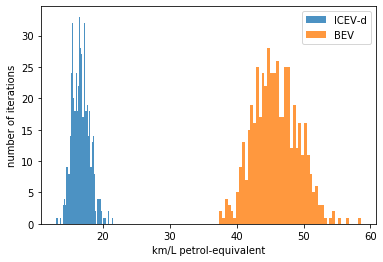

In [23]:
cip = CarInputParameters()
cip.stochastic(500)
#cip.static()
dcts, array = fill_xarray_from_input_parameters(cip,
                                                scope={"powertrain":["ICEV-d", "BEV"],
                                                       "size":["Lower medium"],
                                                       "year":[2017]})
#dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC 3.4')
cm.set_all()
TtW_energy = 1 / (cm.array.sel(size='Lower medium', year=2017, parameter='TtW energy') / 42000) # assuming 42 MJ/L petrol

l_powertrains = TtW_energy.powertrain
[plt.hist(e, bins=50, alpha=.8, label=e.powertrain.values) for e in TtW_energy]
plt.xlabel('km/L petrol-equivalent')
plt.ylabel('number of iterations')
plt.legend()

We can check the randomly generated values for any parameter like so. Here, for the tank to wheel energy in kWh/100 km.

In [24]:
cm.array.sel(size='Lower medium', year=2017, parameter='TtW energy') * 1/3600 * 100

<xarray.DataArray (powertrain: 2, value: 500)>
array([[64.99772814, 73.80474854, 79.00413683, 70.60535346, 75.72557916,
        70.23635525, 66.57974582, 69.74899631, 73.4188029 , 66.45288764,
        72.77156576, 78.78474935, 72.45366753, 70.62256538, 66.47418213,
        64.37181939, 75.04619005, 76.77193197, 75.7329305 , 72.56801351,
        62.11159939, 71.66337077, 74.05659993, 71.20441352, 62.57770454,
        80.99088542, 62.95766195, 72.84883626, 76.31776937, 71.73057726,
        75.89540609, 73.74467638, 68.08648682, 70.82094998, 72.6614719 ,
        74.3773329 , 70.00439453, 72.54986572, 70.65382216, 65.88591851,
        78.63794623, 73.32156711, 70.46652561, 56.4030287 , 72.18703206,
        70.88174778, 71.85274929, 63.26383464, 69.09857178, 73.42819553,
        58.25421821, 67.74310303, 78.44447157, 63.66417101, 65.85755751,
        64.85669623, 67.36963569, 76.01498752, 65.9870402 , 67.68796794,
        62.73010254, 68.83965386, 73.429206  , 66.69043647, 66.57043457,
        63.83321804, 67.05409749, 67.81781684, 67.97755263, 71.82545302,
        81.70027669, 64.88618978, 70.68489583, 65.13554552, 76.35120307,
        68.72509087, 70.46835666, 70.89068604, 72.75878228, 67.99092611,
        68.67649333, 75.66536458, 82.28107368, 64.76125081, 76.01940918,
        69.1422187 , 60.18223063, 67.50005425, 78.48078749, 74.61857775,
        68.63119846, 76.47644043, 68.80206299, 68.14439562, 77.10788981,
        74.6877577 , 67.69683838, 63.22155762, 68.39664035, 77.30273438,
...
        27.13958571, 26.12909444, 26.20101759, 27.55436876, 25.96480476,
        22.48686896, 25.44910007, 25.94835239, 27.98845418, 27.19358826,
        24.03252326, 23.28478665, 26.8417511 , 24.22520955, 26.64761861,
        26.65758091, 28.85478719, 25.75646464, 28.27702671, 24.79473877,
        24.92694092, 25.16307576, 24.4915585 , 21.93014018, 21.10687086,
        27.40201484, 28.81871202, 24.69217088, 28.96765815, 22.67856683,
        27.55669996, 24.03133986, 25.07611762, 24.56613159, 26.0970459 ,
        28.64903429, 23.62605625, 23.65756565, 24.38702732, 26.26367357,
        23.43041144, 28.55640327, 25.78073968, 25.19570584, 23.11659241,
        25.60484992, 25.23406813, 27.55897861, 23.9031016 , 23.62059021,
        25.92060852, 25.15474447, 26.41465251, 24.33521016, 24.65857951,
        25.23844231, 26.1635064 , 24.5330997 , 24.33221266, 27.8036516 ,
        31.02840847, 23.77836439, 23.45928107, 25.96029833, 22.40583632,
        26.65415616, 24.09072367, 27.62988959, 19.93325636, 23.08666823,
        23.5559845 , 23.14484829, 24.41726685, 24.44280497, 24.08436924,
        26.20672438, 25.62602064, 26.06179979, 24.03103638, 28.13807339,
        25.62734307, 26.38135444, 26.96192763, 25.2267829 , 26.33223809,
        25.23457167, 26.64575195, 30.22207303, 23.64757962, 24.5967136 ,
        24.19529046, 22.78738403, 27.57127041, 27.07685852, 29.98906453,
        24.92171224, 24.98265584, 24.0105879 , 27.74167209, 27.40031603]])
Coordinates:
    size        <U12 'Lower medium'
  * powertrain  (powertrain) <U6 'ICEV-d' 'BEV'
    parameter   <U48 'TtW energy'
    year        int32 2017
  * value       (value) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

We can look at noise emissions. We see that most noise is emitted in rural environment. Noise emissions are dependent of the driving cycle chosen.

Text(0, 0.5, 'joules per km')

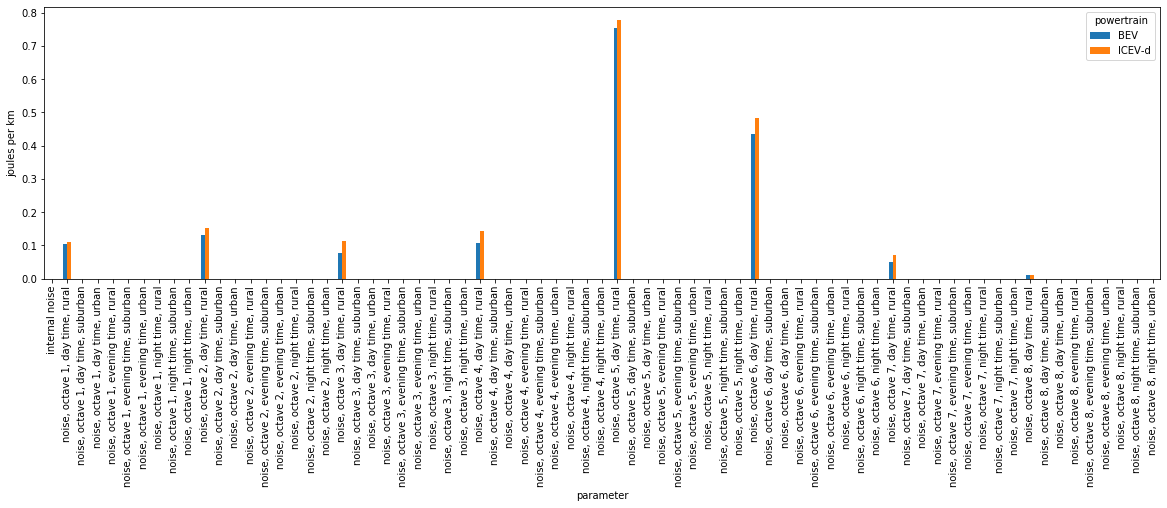

In [25]:
list_param = list(cm.array.parameter.values)
noise_emissions = [x for x in list_param if 'noise' in x]
data = cm.array.sel(parameter=noise_emissions, year=2017, size='Lower medium', value=0)\
    .to_dataframe(name='noise emissions').unstack()['noise emissions'].T
data[data>0].plot(kind='bar', figsize=(20, 5))
plt.ylabel('joules per km')

Calculation of the inventories

In [26]:
cm.array.coords

Coordinates:
  * size        (size) <U12 'Lower medium'
  * powertrain  (powertrain) <U6 'ICEV-d' 'BEV'
  * parameter   (parameter) <U48 'Acetaldehyde direct emissions, rural' ... '...
  * year        (year) int32 2017
  * value       (value) int32 0 1 2 3 4 5 6 7 ... 493 494 495 496 497 498 499

In [27]:
ic = InventoryCalculation(cm.array)

(234, 500, 2)
(719, 719)


We can have a look at the underlying technology matrix

In [28]:
ic.A

array([[[ 1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   , -0.038,  1.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  1.   ]],

       [[ 1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   , -0.038,  1.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.   ,  0.   ,  0.   , ...,  1.   ,  0.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  1.   ,  0.   ],
        [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  1.   ]],

       [[ 1.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   ,  1.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
        [ 0.   , -0.038,  1.   , ...,  0.   ,  0.   ,  0.   ],
        ...,
        [ 0.

The labels of its rows and columns

In [ ]:
ic.inputs

# Impact assessment

For now, only Recipe 2008 and ILCD Midpoint methods are present. LCIA scores can be obtained this way:

In [30]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.static()
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

With ReCiPe 2008

(234, 1, 252)
(993, 993)
****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is RER
 * Power and energy batteries produced in CN using NMC chemistry.
 * in 2000, % of renewable: 19.0%, GHG intensity per kWh: 510 g. CO2-eq.
 	 * in 2010, % of renewable: 31.0%, GHG intensity per kWh: 407 g. CO2-eq.
 	 * in 2017, % of renewable: 38.0%, GHG intensity per kWh: 351 g. CO2-eq.
 	 * in 2040, % of renewable: 53.0%, GHG intensity per kWh: 224 g. CO2-eq.
 * electrolysis is completed by smr - natural gas.
 	 * in 2000 _________________________________________ 0.0%
 	 * in 2010 _________________________________________ 1.0%
 	 * in 2017 _________________________________________ 1.0%
 	 * in 2040 _________________________________________ 8.0%
 * cng is completed by biogas - sewage sludge.
 	 * in 2000 _________________________________________ 0.0%
 	 * in 2010 _________________________________________ 1.0%
 	 * in 2017 _________________________________________

C:\Users\sacchi_r\AppData\Local\Continuum\miniconda3\envs\coarse\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


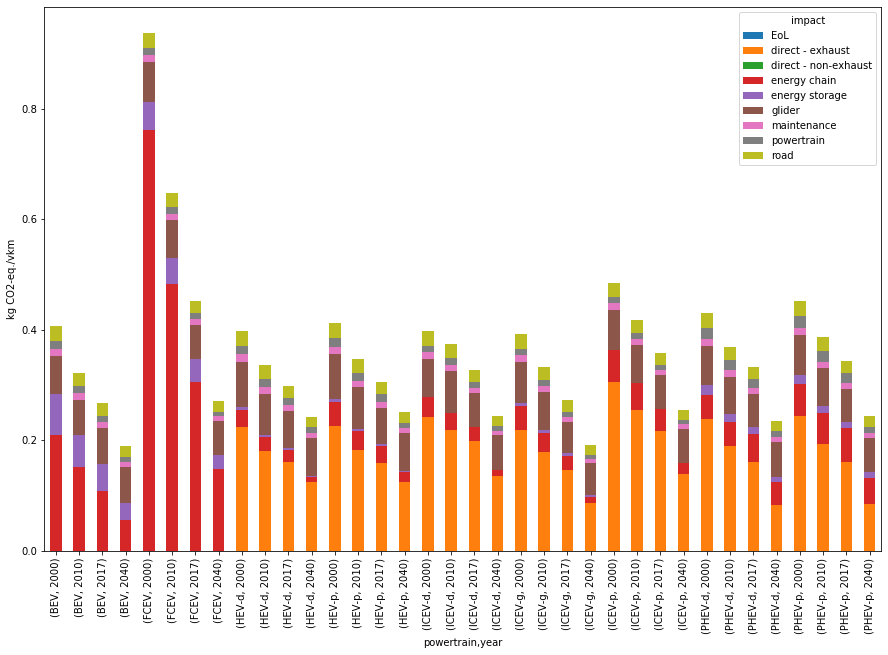

In [31]:
ic = InventoryCalculation(cm.array) # If the argument `method` is left unspecified, ReCiPe is used. It can also be specified epxlicitly.
results = ic.calculate_impacts()

results.sel(impact_category='climate change', size='Large', value=0)\
    .to_dataframe('impact')\
    .unstack(level=2)['impact']\
    .plot(kind='bar',
                stacked=True,
         figsize=(15,10))
plt.ylabel('kg CO2-eq./vkm')
plt.show()

With ILCD 2018

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is RER
 * Power and energy batteries produced in CN using NMC chemistry.
 * in 2000, % of renewable: 51.0%, GHG intensity per kWh: 457 g. CO2-eq.
 	 * in 2010, % of renewable: 51.0%, GHG intensity per kWh: 383 g. CO2-eq.
 	 * in 2017, % of renewable: 51.0%, GHG intensity per kWh: 340 g. CO2-eq.
 	 * in 2040, % of renewable: 51.0%, GHG intensity per kWh: 248 g. CO2-eq.
 * electrolysis is completed by smr - natural gas.
 	 * in 2000 _________________________________________ 0.0%
 	 * in 2010 _________________________________________ 1.0%
 	 * in 2017 _________________________________________ 1.0%
 	 * in 2040 _________________________________________ 8.0%
 * cng is completed by biogas.
 	 * in 2000 _________________________________________ 0.0%
 	 * in 2010 _________________________________________ 1.0%
 	 * in 2017 _________________________________________ 1.0%
 	 * in 2040 ______________________

C:\Users\sacchi_r\AppData\Local\Continuum\miniconda3\envs\coarse\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


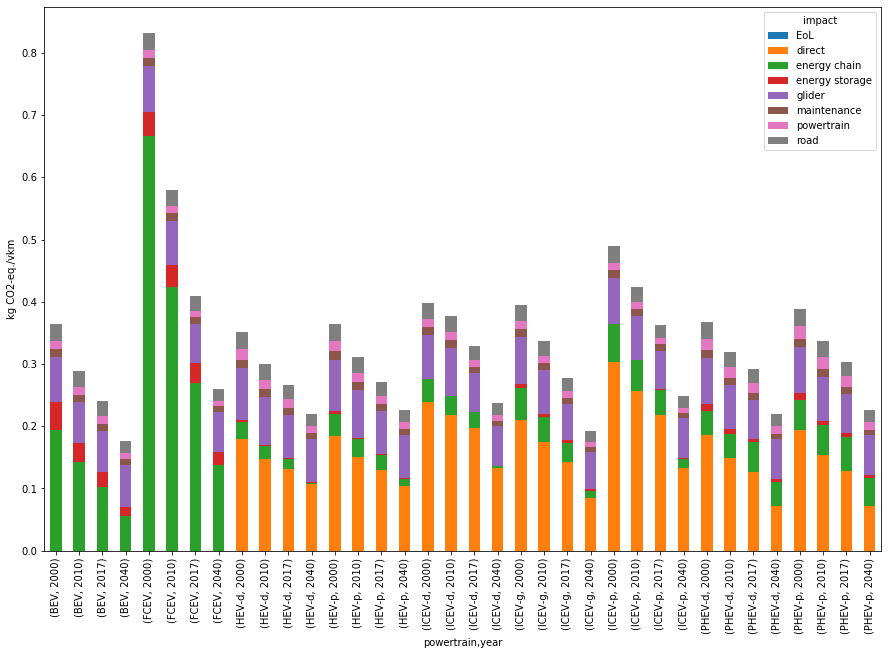

In [4]:
ic = InventoryCalculation(cm.array, method="ilcd") # Here, ILCD is specified.
results = ic.calculate_impacts()

results.sel(impact_category='climate change - climate change total', size='Large', value=0)\
    .to_dataframe('impact')\
    .unstack(level=2)['impact']\
    .plot(kind='bar',
                stacked=True,
         figsize=(15,10))
plt.ylabel('kg CO2-eq./vkm')
plt.show()

The names of the cateogries for Recipe 2008 and ILCD 2018 are different. They can be obtained like so:

In [5]:
ic.get_dict_impact_categories()

{'recipe': {'midpoint': ['metal depletion',
   'agricultural land occupation',
   'climate change',
   'fossil depletion',
   'freshwater ecotoxicity',
   'freshwater eutrophication',
   'human toxicity',
   'ionising radiation',
   'marine ecotoxicity',
   'marine eutrophication',
   'natural land transformation',
   'ozone depletion',
   'particulate matter formation',
   'photochemical oxidant formation',
   'terrestrial acidification',
   'terrestrial ecotoxicity',
   'urban land occupation',
   'water depletion',
   'human noise',
   'primary energy, renewable',
   'primary energy, non-renewable']},
 'ilcd': {'midpoint': ['ecosystem quality - freshwater ecotoxicity',
   'human health - non-carcinogenic effects',
   'human health - carcinogenic effects',
   'resources - minerals and metals',
   'climate change - climate change biogenic',
   'climate change - climate change fossil',
   'climate change - climate change land use and land use change',
   'climate change - climate chang

We can specify a scope, to narrow the analysis down to specific vehicles. A scope dictionary needs to have the following format:

In [22]:
scope = {
    "size":["Small"],
    "powertrain":["ICEV-d"],
    "year":[2017]
}

Not all the key:values need to be included. If a key is missing, no filter for that key will apply.

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is RER
 * Power and energy batteries produced in CN using NMC chemistry.
 * The electricity mix is provided by carculator.
 	 * in 2000, % of renewable _________________________ 19.0%
 	 * in 2010, % of renewable _________________________ 30.0%
 	 * in 2017, % of renewable _________________________ 38.0%
 	 * in 2040, % of renewable _________________________ 51.0%
 * diesel is completed by biodiesel - algae.
 	 * in 2000 _________________________________________ 0.0%
 	 * in 2010 _________________________________________ 1.0%
 	 * in 2017 _________________________________________ 1.0%
 	 * in 2040 _________________________________________ 8.0%
 * *********************************************************************


C:\Users\romai\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


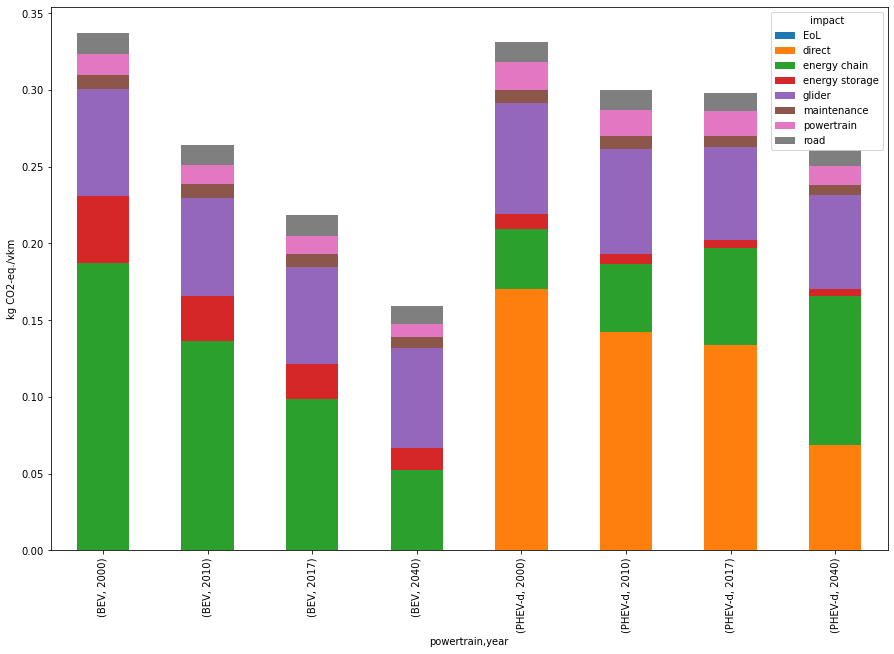

In [23]:
scope = {
    'powertrain':['BEV', 'PHEV-d'],
}
ic = InventoryCalculation(cm.array, scope=scope)
results = ic.calculate_impacts()
results.sel(impact_category='climate change', size='Large', value=0)\
    .to_dataframe('impact')\
    .unstack(level=2)['impact']\
    .plot(kind='bar',
                stacked=True,
         figsize=(15,10))
plt.ylabel('kg CO2-eq./vkm')
plt.show()

## Integrated Assessment Model (IAM) 

Scenario outputs of IAM are used to modify the background inventories used to calculate the impacts of the vehicles, to reflect future expected changes in the energy-intensive sectors.

Currently, carculator uses scenario outputs of the IAM called REMIND, developed by PIK.

The outputs of the REMIND scenarios are used to modify the way electricity will be produced in the future as well as its supply markets for different work regions, but also other industrial sectors (cement, stell, heat, chemicals, etc.). The choice of scenario will also change the suggested fuel blands for different fuels, unless they are overridden by the user.

By default, when performing the impact assessment of vehicles, carculator uses REMIND-modified background inventories corresponding to the year of production of the vehicles, for a given energy scenario.

Three energy scenario are offered:
* SSP2-Baseline": business-as-usual, no climate policy is enforced, leading to a global temperature rise of 3.5 degrees Celsius by 2100,
* "SSP2-PkBudg1100": limits cumulative GHG emissions to 1,100 gigatons by 2100, leading to a global temperature rise well-below 2 degrees Celsius by 2100,
* "static": no forward-looking modification of the background inventories is done.

The scenario chosen should be passed as an argument to `InventoryCalculation()`. By default, "SSP2-Baseline" is chosen.

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is RER
 * Power and energy batteries produced in CN using NMC chemistry.
 * The electricity mix is provided by carculator.
 	 * in 2000, % of renewable _________________________ 19.0%
 	 * in 2010, % of renewable _________________________ 31.0%
 	 * in 2017, % of renewable _________________________ 38.0%
 	 * in 2040, % of renewable _________________________ 51.0%
 * diesel is completed by biodiesel - algae.
 	 * in 2000 _________________________________________ 0.0%
 	 * in 2010 _________________________________________ 1.0%
 	 * in 2017 _________________________________________ 2.0%
 	 * in 2040 _________________________________________ 18.0%
 * *********************************************************************


C:\Users\romai\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


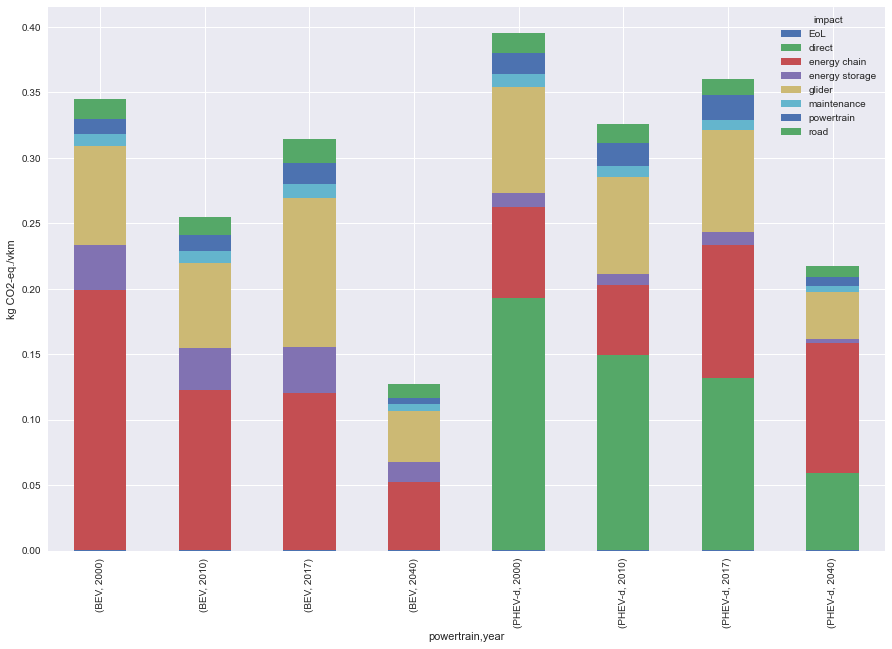

In [31]:
scope = {
    'powertrain':['BEV', 'PHEV-d'],
}
ic = InventoryCalculation(cm.array, scope=scope, scenario="SSP2-PkBudg1100")
results = ic.calculate_impacts()
results.sel(impact_category='climate change', size='Large', value=0)\
    .to_dataframe('impact')\
    .unstack(level=2)['impact']\
    .plot(kind='bar',
                stacked=True,
         figsize=(15,10))
plt.ylabel('kg CO2-eq./vkm')
plt.show()

## Monte Carlo analysis

The calling of functions does not change, except that we call `cip.stochastic()` instead of `cip.static()`. For example here, we do a Monte Carlo analysis with 500 iterations, for Large BEVs and PHEV-d only.

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is RER
 * Power and energy batteries produced in CN using NMC chemistry.
 * The electricity mix is provided by carculator.
 	 * in 2000, % of renewable _________________________ 19.0%
 	 * in 2010, % of renewable _________________________ 31.0%
 	 * in 2017, % of renewable _________________________ 38.0%
 	 * in 2040, % of renewable _________________________ 51.0%
 * diesel is completed by biodiesel - algae.
 	 * in 2000 _________________________________________ 0.0%
 	 * in 2010 _________________________________________ 1.0%
 	 * in 2017 _________________________________________ 1.0%
 	 * in 2040 _________________________________________ 8.0%
 * *********************************************************************


C:\Users\romai\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Text(0, 0.5, 'kg CO2-eq./vkm')

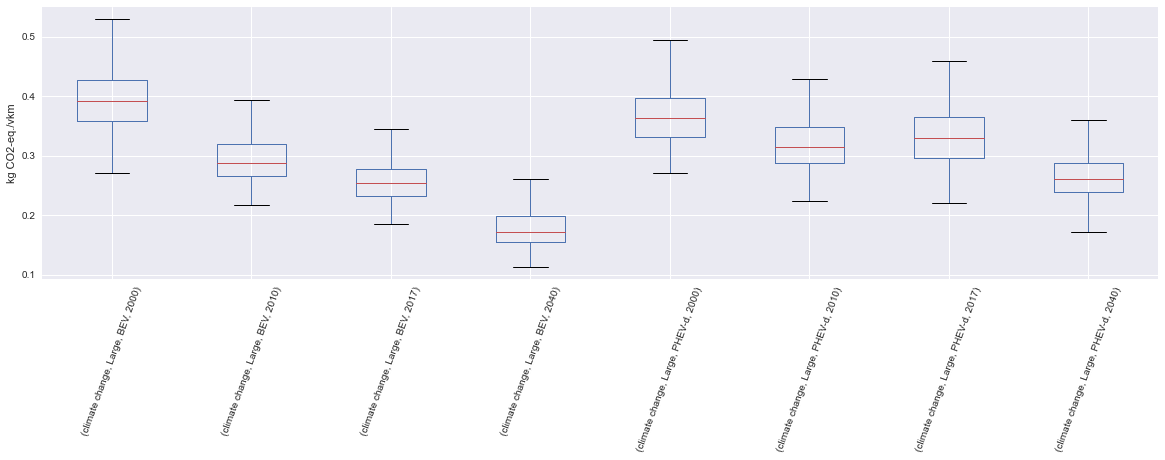

In [24]:
cip = CarInputParameters()
cip.stochastic(500)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
scope = {
    'powertrain':['BEV', 'PHEV-d'],
    'size':['Large']
}
ic = InventoryCalculation(cm.array, scope=scope)

results = ic.calculate_impacts()

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')

## Background assumptions

We can specify a number of different background assumptions such as:
* the electricity mix to be used during the Use phase (i.e., battery chanrging, hydrogen production, etc.)
* fuels pathways (bioethanol instead of gasoline, hydrogen from steam methane reforming instead of electrolysis, synthetic fuels)
* the blend for different fuels (e.g., % of biodiesel vs. % of conventional diesel)
* the energy storage technologies (e.g., different battery chemistries: NMC, LFP, NCA, etc.)
* ...

For example, we wish to charge BEV batteries with German electricity

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is RER
 * Power and energy batteries produced in CN using NMC chemistry.
 * The electricity mix is provided by carculator.
 	 * in 2017, % of renewable _________________________ 32.0%
 	 * in 2040, % of renewable _________________________ 41.0%
 * Gasoline is completed by bioethanol - wheat straw.
 	 * in 2017 _________________________________________ 1.0%
 	 * in 2040 _________________________________________ 6.0%
 * *********************************************************************


C:\Users\romai\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Text(0, 0.5, 'kg CO2-eq./vkm')

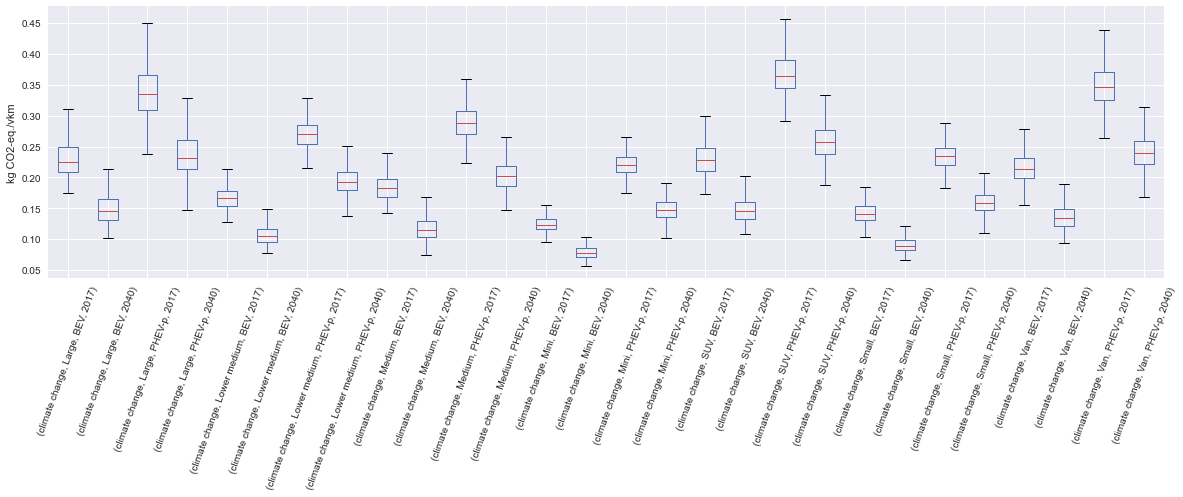

In [25]:
scope = {
    'powertrain':['BEV', 'PHEV-p'],
}

background_configuration = {
   'background_country' : 'DE' 
}

ic = InventoryCalculation(cm.array, scope=scope, background_configuration = background_configuration)

results = ic.calculate_impacts()

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')

Or with a specific electricity mix in mind...

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is DE
 * Power and energy batteries produced in CN using NMC chemistry.
 * The electricity mix is provided by the user.
 	 * in 2017, % of renewable _________________________ 50.0%
 	 * in 2040, % of renewable _________________________ 50.0%
 * Gasoline is completed by bioethanol - wheat straw.
 	 * in 2017 _________________________________________ 1.0%
 	 * in 2040 _________________________________________ 6.0%
 * *********************************************************************


C:\Users\romai\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


Text(0, 0.5, 'kg CO2-eq./vkm')

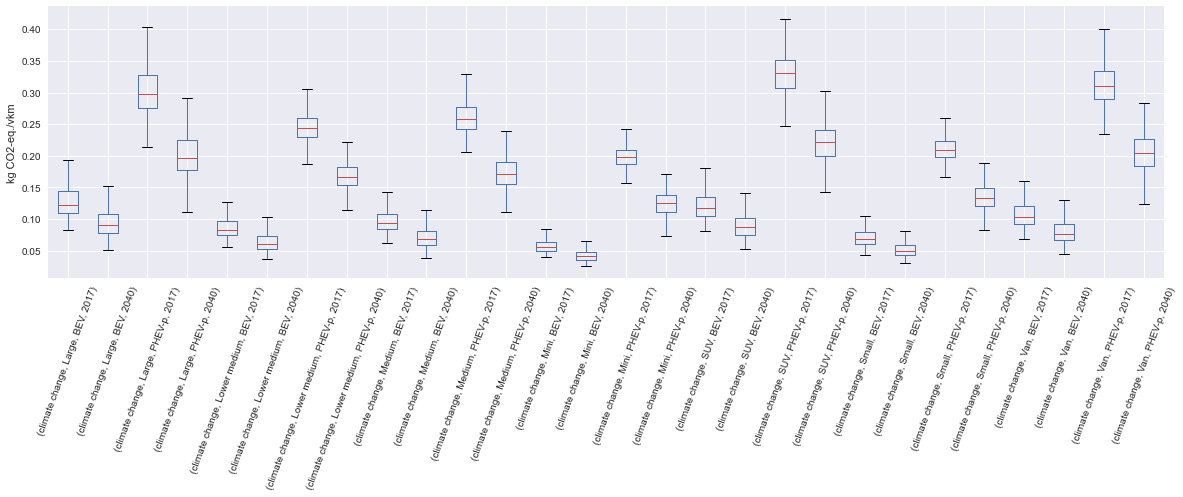

In [27]:
scope = {
    'powertrain':['BEV', 'PHEV-p'],
}

"""
0: Hydro
1: Nuclear
2: Gas
3: Solar
4: Wind
5: Biomass
6: Coal
7: Oil
8: Geothermal
9: Waste
"""
background_configuration = {
    'country' : 'DE', # will use the network electricity losses of Germany
    'custom electricity mix' : [[.5,.5,0,0,0,0,0,0,0,0],
                                [.5,.5,0,0,0,0,0,0,0,0]] # in this case, 50% hydro, 50% nuclear
}
ic = InventoryCalculation(cm.array, scope=scope, background_configuration = background_configuration)
results = ic.calculate_impacts()

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')

We can also change the fuel pathways for different fuels or blend them:
* diesel: conventional, biodiesel, synthetic diesel
* petrol: conventional, bio-ethanol, synthetic gasoline
* gas: conventional, bio-methane, synthetic methane
* hydrogen: electrolysis, steam methane reforming of biogas, steam methane reforming of natural gas, from coal-gasification, etc.
* electricity: country mix or custom mix

**Note that not all fuels have the same lower heating value. Hence, the range of the vehicles will be adjusted to the blend specified.**

As well as choose from a few technologies for energy storage:
* battery: LFP, NMC or NCA chemistries
* battery: country of manufacture
* hydrogen tanks: carbon fiber, hdpe liner, aluminium liner.


For example here, we compare, over 500 iterations, BEV to FCEV to ICEV-p, with:
* custom electricity mixes for 2017 and 2040,
* with hydrogen produced by electrolysis,
* a gasoline blend made of gasoline and bioethanol from wheat straw,
* and a NMC type battery for the BEV, made in Norway
* as well as a carbon fiber-based tank for storing the hydrogen.

Note that, if unspecified, projected fuel blend shares from the IAM model REMIND are used instead.
Also, if unspecified, NMC batteries produced in China are used by default.

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is CH
 * Power and energy batteries produced in NO using NMC chemistry.
 * in 2000, % of renewable: 100%, GHG intensity per kWh: 4 g. CO2-eq.
 	 * in 2010, % of renewable: 100%, GHG intensity per kWh: 11 g. CO2-eq.
 	 * in 2017, % of renewable: 100%, GHG intensity per kWh: 675 g. CO2-eq.
 	 * in 2040, % of renewable: 100%, GHG intensity per kWh: 76 g. CO2-eq.
 * electrolysis is completed by smr - natural gas.
 	 * in 2000 _________________________________________ 0%
 	 * in 2010 _________________________________________ 100%
 	 * in 2017 _________________________________________ 100%
 	 * in 2040 _________________________________________ 100%
 * petrol is completed by bioethanol - wheat straw.
 	 * in 2000 _________________________________________ 10.0%
 	 * in 2010 _________________________________________ 20.0%
 	 * in 2017 _________________________________________ 30.0%
 	 * in 2040 _________

C:\Users\sacchi_r\AppData\Local\Continuum\miniconda3\envs\coarse\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


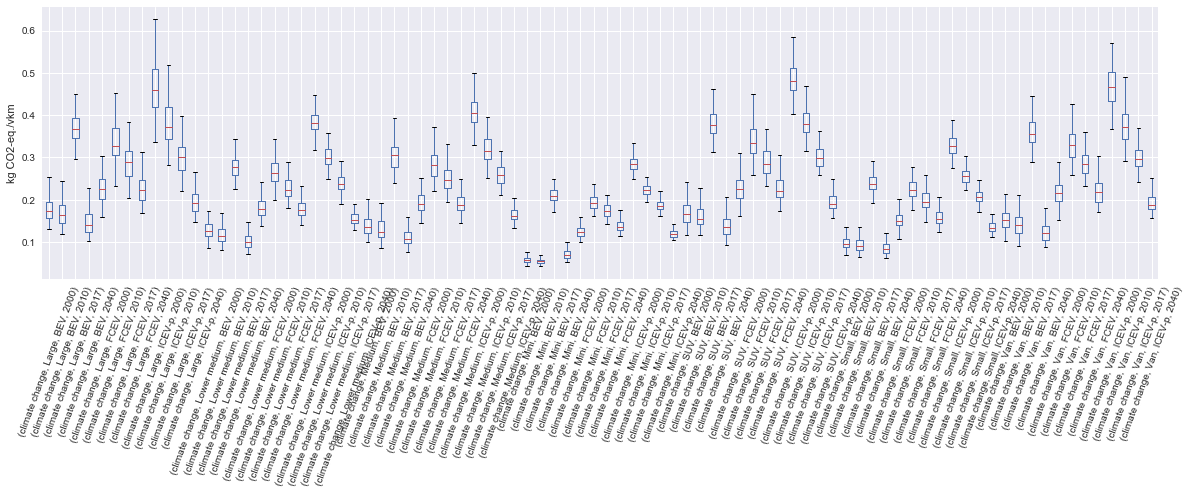

In [6]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.stochastic(100)
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()
ic = InventoryCalculation(cm.array)



"""
Electricity mixes
-----------------
0: Hydro
1: Nuclear
2: Gas
3: Solar
4: Wind
5: Biomass
6: Coal
7: Oil
8: Geothermal
9: Waste

Hydrogen technologies (LHV: 120 MJ/kg)
--------------------------------------
'electrolysis'
'smr - natural gas'
'smr - natural gas with CCS'
'smr - biogas'
'smr - biogas with CCS'
'coal gasification'
'wood gasification'
'wood gasification with CCS'

Natural gas technologies
------------------------
'cng' (55.5 MJ/kg, 2.65 kg CO2/kg CNG)
'biogas' (55.5 MJ/kg, 2.65 kg CO2/kg CNG)
'syngas' (55.5 MJ/kg, 2.65 kg CO2/kg CNG)

Diesel technologies
-------------------
'diesel' (42.8 MJ/kg, 3.14 kg CO2/kg)
'biodiesel - algae' (31.7 MJ/kg, 2.85 kg CO2/kg)
'biodiesel - cooking oil' (31.7 MJ/kg, 2.85 kg CO2/kg)
'synthetic diesel' (43.3 MJ/kg, 3.14 kg CO2/kg)

Petrol technologies
-------------------
'petrol' (42.4 MJ/kg, 3.18 kg CO2/kg)
'bioethanol - wheat straw' (26.8 MJ/kg, 1.91 kg CO2/kg)
'bioethanol - maize starch' (26.8 MJ/kg, 1.91 kg CO2/kg)
'bioethanol - sugarbeet' (26.8 MJ/kg, 1.91 kg CO2/kg)
'bioethanol - forest residues' (26.8 MJ/kg, 1.91 kg CO2/kg)
'synthetic gasoline' (42.4 MJ/kg, 3.18 kg CO2/kg)

"""

bc = {'country':'CH', # considers electricity network losses for Switzerland
      'custom electricity mix' : [[1,0,0,0,0,0,0,0,0,0], # in this case, 100% hydropower for the first year
                                  [0,1,0,0,0,0,0,0,0,0],
                                  [0,0,1,0,0,0,0,0,0,0],
                                  [0,0,0,1,0,0,0,0,0,0],
                                 ], # in this case, 100% nuclear for the second year
      'fuel blend':{
          'cng':{ #specify fuel bland for compressed gas
                'primary fuel':{
                    'type':'biogas', 
                    'share':[0.9, 0.8, 0.7, 0.6] # shares per year. Must total 1 for each year.
                    },
                'secondary fuel':{
                    'type':'syngas',
                    'share': [0.1, 0.2, 0.3, 0.4]
                    }
                },
         'diesel':{
                'primary fuel':{
                    'type':'synthetic diesel', 
                    'share':[0.9, 0.8, 0.7, 0.6]
                    },
                'secondary fuel':{
                    'type':'biodiesel - cooking oil',
                    'share': [0.1, 0.2, 0.3, 0.4]
                    }
                },
         'petrol':{
                'primary fuel':{
                    'type':'petrol', 
                    'share':[0.9, 0.8, 0.7, 0.6]
                    },
                'secondary fuel':{
                    'type':'bioethanol - wheat straw',
                    'share': [0.1, 0.2, 0.3, 0.4]
                    }
                },
        'hydrogen':{
                'primary fuel':{'type':'electrolysis', 'share':[1, 0, 0, 0]},
                'secondary fuel':{'type':'smr - natural gas', 'share':[0, 1, 1, 1]}
                }
            },
      'energy storage': {
          'electric': {
              'type':'NMC',
              'origin': 'NO'
          },
          'hydrogen': {
              'type':'carbon fiber'
          }
      }
     }

scope = {
    'powertrain':['BEV', 'FCEV', 'ICEV-p'],
}

ic = InventoryCalculation(cm.array, scope=scope, background_configuration = bc)
results = ic.calculate_impacts()

data_MC = results.sel(impact_category='climate change').sum(axis=3).to_dataframe('climate change')
plt.style.use('seaborn')
data_MC.unstack(level=[0,1,2]).boxplot(showfliers=False, figsize=(20,5))
plt.xticks(rotation=70)
plt.ylabel('kg CO2-eq./vkm')
plt.show()

The fuel blends, the lower heating value of the fuels and the CO2 emission factor used can be accessed like so:

In [7]:
ic.fuel_blends

{'petrol': {'primary': {'type': 'petrol',
   'share': [0.9, 0.8, 0.7, 0.6],
   'lhv': 42.4,
   'CO2': 3.18},
  'secondary': {'type': 'bioethanol - wheat straw',
   'share': array([0.1, 0.2, 0.3, 0.4]),
   'lhv': 26.8,
   'CO2': 1.91}},
 'hydrogen': {'primary': {'type': 'electrolysis', 'share': [1, 0, 0, 0]},
  'secondary': {'type': 'smr - natural gas', 'share': array([0, 1, 1, 1])}}}

# Sensitivity analysis

`carculator` has a function to claculate the sensitivity of characterized results in regard to the inputs parameters of `CarModel`. This function generates a number of "scenarios" within which one input parameter has its value increased by 10%. The newly calculated results are stored and compared to the reference scneario (where none of the input parameter values are modified).

To do so, we run the model in **static** mode, but we give the argument `sensitivity=True` to `fill_xarray_from_input_parameters()` and `calculate_impacts()`.

In [29]:
from carculator import *
import matplotlib.pyplot as plt
import numpy as np
cip = CarInputParameters()
cip.static()

_, array = fill_xarray_from_input_parameters(cip, sensitivity=True)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

ic = InventoryCalculation(cm.array, scope={"size":["Large"], "powertrain":["ICEV-d", "BEV"], "year":[2017]})
res = ic.calculate_impacts(sensitivity=True)

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is RER
 * Power and energy batteries produced in CN using NMC chemistry.
 * The electricity mix is provided by carculator.
 	 * in 2017, % of renewable _________________________ 32.0%
 * Diesel is completed by biodiesel - algae.
 	 * in 2017 _________________________________________ 1.0%
 * *********************************************************************


C:\Users\romai\AppData\Roaming\Python\Python37\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:133: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  SparseEfficiencyWarning)


We retrieve an array that contains characterized results for a number of scenarios (where only one parameter value is increased in each scenario), normalized in regard to the reference scenario. Hence, values above 1 indicate that increasing the parameter value given in the `parameter` dimension of the array by 10% led to an increase in the characterized results (for the impact category selected).

We can turn the array into a `pandas` dataframe for better visualization. We can also remove the results that equal to 1 (which indicate that increasing the value of the selected parameter by 10% had no influence on the characterized result).

Let's see the result for a battery electric vehicle in 2017, in regard to the impact category **Climate change**.

Text(0.5, 1.0, 'Parameters value increased by 10%')

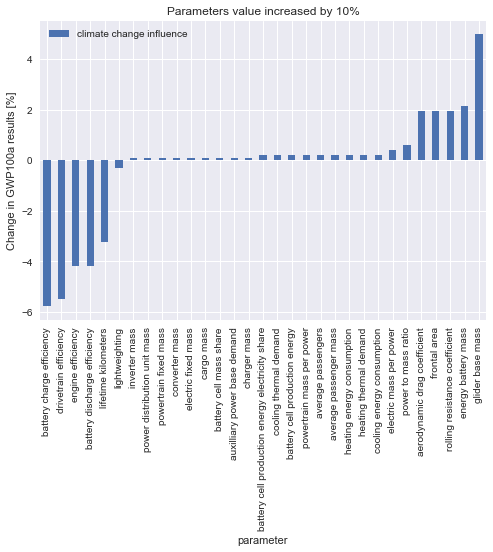

In [30]:
df = res.sel(impact_category="climate change", powertrain="BEV", size="Large", year=2017).to_dataframe("climate change influence")
df = df.loc[df["climate change influence"] != 1,:]
df["climate change influence"] -= 1 
df["climate change influence"] *= 100 
df = df.sort_values("climate change influence", ascending=True)
df.plot(y = "climate change influence", kind="bar")
plt.ylabel("Change in GWP100a results [%]")
plt.title("Parameters value increased by 10%")

Therefore, we can see that the characterized results for **Climate change** are negatively influenced by changes of +10% in the parameter value for the charge and discharge efficiency of the battery as well as the drivetrain and engine efficiency.

On the other end, the results are positively influenced by changes in the parameter value for the glider base mass, the mas s of the battery and the aerodynamic of the vehicle.

# Export inventories

Inventories in `static` calculation mode can be exported to different formats:
* as an Excel file compatible for import with `brightway2`
* a Brightway2 LCIImporter object
* a Python dictionary

## Export inventories without uncertainty 

Inventories are exported to an Excel file which can later be imported into `brightway2`. The `export_to_excel()` function returns the filepath where the Excel file can be found (the same directory as the script calling it).

In [11]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
cip.static()
dcts, array = fill_xarray_from_input_parameters(cip)
cm = CarModel(array, cycle='WLTC')
cm.set_all()

scope = {
    'powertrain':['ICEV-d', 'PHEV'],
}

ic = InventoryCalculation(cm.array, scope=scope)

ic.export_lci_to_excel(software_compatibility="brightway2")

Here, the inventory is instead returned as a `brightway2` LCIImporter object, which can be directly registered into `brightway2`.

Currently, the inventories can be exported so as to link with **ecoinvent cut-off** 3.5, 3.6 and 3.7. The ecoinvent version can be specified in the `ecoinvent_version` argument. Here with ecoinvent 3.6:

In [2]:
i, _ = ic.export_lci_to_bw(ecoinvent_version='3.6')

0% [##############################] 100% | ETA: 00:00:00 | Item ID: 691
Total time elapsed: 00:00:00


In [5]:
import brightway2 as bw
bw.projects.set_current('import_36_for_carculator')

if "additional_biosphere" in bw.databases:
    del bw.databases['additional_biosphere']
if "carculator export" in bw.databases:
    del bw.databases['carculator export']
    i.apply_strategies()

i.match_database('ecoinvent 3.6 cutoff', fields=('name', 'unit', 'location', 'reference product'))
i.match_database("biosphere3", fields=('name', 'unit', 'categories'))
i.match_database(fields=('name', 'unit', 'location', 'reference product'))
i.match_database(fields=('name', 'unit', 'categories'))
i.create_new_biosphere("additional_biosphere", relink=True)
i.statistics()
i.write_database()

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: assign_only_product_as_production
Applying strategy: strip_biosphere_exc_locations
Applied 4 strategies in 0.01 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Creating new biosphere database: additional_biosphere
Applying strategy: link_iterable_by_fields
Applied 1 strategies in 0.05 seconds
264 datasets
7959 exchanges
0 unlinked exchanges
  


(264, 7959, 0)

Once the export database registered, the user can perform LCAs, like so:

In [5]:
import brightway2 as bw
bw.projects.set_current('MCDA')

In [6]:
bw.databases

Databases dictionary with 42 objects, including:
	MCDA_BEV_FCEV_ACP_new
	MCDA_BEV_FCEV_EACP_new
	MCDA_BEV_FCEV_MCP_new
	MCDA_BEV_biogas_CCS_EACP_new
	MCDA_BEV_ng_CCS_EACP_new
	MCDA_BEV_wood_CCS_EACP_new
	MCDA_FCEV_smr_CCS_EACP_new
	MCDA_FCEV_smr_EACP_new
	MCDA_FCEV_smr_MCP_new
	MCDA_FCEV_smr_biogas_CCS_EACP_new
Use `list(this object)` to get the complete list.

In [8]:
FU = [{act:1} for act in bw.Database('MCDA_BEV_FCEV_ACP_new') if 'Passenger' in act['name'] and 'Lower medium' in act['name']]
FU

[{'Passenger car, FCEV, Lower medium, 2050, EURO-6' (kilometer, CH, None): 1},
 {'Passenger car, BEV, Lower medium, 2050, EURO-6' (kilometer, CH, None): 1}]

In [9]:
import pandas as pd
bw.calculation_setups['multiLCA'] = {'inv': FU, 'ia': [('IPCC 2013', 'climate change', 'GWP 100a')]}
myMultiLCA = bw.MultiLCA('multiLCA')
df_impact = pd.DataFrame(columns = [('IPCC 2013', 'climate change', 'GWP 100a')],
                         data = myMultiLCA.results,
                         index=[(k['name'], k['location'], k["database"]) for i in FU for k in i])

df_impact.head()

,"(IPCC 2013, climate change, GWP 100a)"
"(Passenger car, FCEV, Lower medium, 2050, EURO-6, CH, MCDA_BEV_FCEV_ACP_new)",0.068593
"(Passenger car, BEV, Lower medium, 2050, EURO-6, CH, MCDA_BEV_FCEV_ACP_new)",0.057347


Because the exchanges of the export inventories are tagged by main impact categories (e.g., direct, glider, powertrain, maintenance, etc.), it is also possible to do a contribution analysis by traversing the supply chain of the product system:

In [10]:
import bw2analyzer as bw2a
d = bw2a.traverse_tagged_databases(FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'))
d[0]

defaultdict(int, {'other': 0.06457794807119699})

Also, the inventories can be made compatible with modified ecoinvent databases, such as those from `premise` (https://github.com/romainsacchi/premise), to allow for prospective LCA. In such case, the argument `ecoinvent_compatibility` must be set to `False`.

In [13]:
i, _ = ic.export_lci_to_bw(ecoinvent_compatibility=False, software_compatibility="brightway2")

****************** IMPORTANT BACKGROUND PARAMETERS ******************
 * The country of use is CH
 * Power and energy batteries produced in NO using NMC chemistry.
 * in 2000, % of renewable: 100%, GHG intensity per kWh: 4 g. CO2-eq.
 	 * in 2010, % of renewable: 100%, GHG intensity per kWh: 11 g. CO2-eq.
 	 * in 2017, % of renewable: 100%, GHG intensity per kWh: 675 g. CO2-eq.
 	 * in 2040, % of renewable: 100%, GHG intensity per kWh: 76 g. CO2-eq.
 * electrolysis is completed by smr - natural gas.
 	 * in 2000 _________________________________________ 0%
 	 * in 2010 _________________________________________ 100%
 	 * in 2017 _________________________________________ 100%
 	 * in 2040 _________________________________________ 100%
 * petrol is completed by bioethanol - wheat straw.
 	 * in 2000 _________________________________________ 10.0%
 	 * in 2010 _________________________________________ 20.0%
 	 * in 2017 _________________________________________ 30.0%
 	 * in 2040 _________

0% [##############################] 100% | ETA: 00:00:00 | Item ID: 744
Total time elapsed: 00:00:00


Inventories can also be imported as SimaPro CSV files, to be imported into SimaPro 9.x (which uses ecoinvent 3.6 cutoff).
This will return the file path where the CSV file has been saved.

In [ ]:
i, _ = ic.export_lci_to_excel(software_compatibility="simapro", ecoinvent_version='3.6')

Note that you can specify a directory where the file you should be saved.

In [ ]:
i, _ = ic.export_lci_to_excel(software_compatibility="simapro",
                              ecoinvent_version='3.6',
                              directory=r"a_file/path/here")

Finally, the inventory can be exported as a Python dictionary

In [6]:
lci, _ = ic.export_lci()

0% [##############################] 100% | ETA: 00:00:00 | Item ID: 691
Total time elapsed: 00:00:00


In [7]:
lci[0]

{'production amount': 1,
 'database': 'carculator export',
 'name': 'Electricity, high voltage, natural gas CCPP, at grid',
 'unit': 'kilowatt hour',
 'location': 'RER',
 'exchanges': [{'name': 'Electricity, high voltage, natural gas CCPP, at grid',
   'database': 'carculator export',
   'amount': 1.0,
   'unit': 'kilowatt hour',
   'type': 'production',
   'location': 'RER',
   'reference product': 'Electricity, high voltage, natural gas CCPP, at grid',
   'uncertainty type': 0},
  {'name': 'transmission network construction, long-distance',
   'database': 'carculator export',
   'amount': 3.17e-10,
   'unit': 'kilometer',
   'type': 'technosphere',
   'location': 'UCTE',
   'reference product': 'transmission network, long-distance',
   'uncertainty type': 0},
  {'name': 'Ozone',
   'database': 'biosphere3',
   'amount': 4.158e-06,
   'unit': 'kilogram',
   'type': 'biosphere',
   'categories': ('air',),
   'uncertainty type': 0},
  {'name': 'electricity production, natural gas, combi

# Export inventories with uncertainty

Additionally, if the model has been run in `stochastic` mode, the exported inventories will include uncertainty information. The uncertainty of a given exchange is expressed as an array of values to be reused for pre-sampling by `brightway2`.

Therefore, alongside the inventory, an array that stores the pre-sampled random values generated by CarModel for each uncertain exchange is returned. This array of pre-sampled values can then be passed to the Monte Carlo function of `brightway2` which will use these values instead of randomly generated ones. This has the advantage of preserving the relation between inputs and outputs of a same activity.


In [1]:
from carculator import *
import matplotlib.pyplot as plt
cip = CarInputParameters()
# 1000 iterations
cip.stochastic(1000)
_, array = fill_xarray_from_input_parameters(cip)
array = array.interp(year=[2028, 2042],  kwargs={'fill_value': 'extrapolate'})
cm = CarModel(array, cycle='NEDC')
cm.set_all() 

0% [##############################] 100% | ETA: 00:00:00 | Item ID: 594
Total time elapsed: 00:00:00


Build the inventory for a large diesel car in 2028

In [ ]:
ic = InventoryCalculation(cm.array, scope={"size":['Large'], "powertrain":['ICEV-d'], "year":[2028]})

Receive the inventory as a brightway2 LCIImporter object, as well as the arrays that contain pre-sampled values

In [ ]:
lci, arr = ic.export_lci_to_bw()

Open a brightway2 project where ecoinvent 3.6 is installed

In [2]:
import brightway2 as bw
bw.projects.set_current('import_36_for_carculator')

Import the inventory into the Brightway project

In [3]:
import bw2io
i = lci
if "additional_biosphere" in bw.databases:
    del bw.databases['additional_biosphere']
if "carculator export" in bw.databases:
    del bw.databases['carculator export']
i.apply_strategies()

i.match_database('ecoinvent 3.6 cutoff', fields=('name', 'unit', 'location', 'reference product'))
i.match_database("biosphere3", fields=('name', 'unit', 'categories'))

i.match_database(fields=('name', 'unit', 'location', 'reference product'))
i.match_database(fields=('name', 'unit', 'categories'))
i.create_new_biosphere("additional_biosphere", relink=False)
i.match_database("additional_biosphere", fields=('name', 'unit', 'categories'))
i.statistics()
i.write_database()

Applying strategy: normalize_units
Applying strategy: drop_unspecified_subcategories
Applying strategy: assign_only_product_as_production
Applying strategy: strip_biosphere_exc_locations
Applied 4 strategies in 0.00 seconds
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Applying strategy: link_iterable_by_fields
Creating new biosphere database: additional_biosphere
Applying strategy: link_iterable_by_fields
167 datasets
1402 exchanges
0 unlinked exchanges
  


Writing activities to SQLite3 database:
0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:00


Title: Writing activities to SQLite3 database:
  Started: 12/16/2019 13:41:55
  Finished: 12/16/2019 13:41:55
  Total time elapsed: 00:00:00
  CPU %: 73.50
  Memory %: 41.36
Created database: carculator export


Brightway2 SQLiteBackend: carculator export

While simple LCA calculations can be directly performed on the newly imported inventory, for Monte Carlo analyses with presamples, the imported inventory needs to be merged with the ecoinvent database.
Merge the newly imported inventory with ecoinvent 3.6

In [5]:
import bw2data
bw2data.utils.merge_databases('ecoinvent 3.6 cutoff', 'carculator export')

We need to reformat the pre-samples array with the correct activity codes

In [6]:
l_flows = []
for a in arr:
    l_flows.extend([a[1][0][0], a[1][0][1]])

l_flows = set(l_flows)
d_flows = {}


for ds in bw.Database('biosphere3'):
    if (ds['name'], tuple(ds['categories']), ds['unit']) in l_flows:
        d_flows[(ds['name'], tuple(ds['categories']), ds['unit'])] = (ds['database'], ds['code'])

for ds in bw.Database('carculator export'):
    if (ds['name'], ds['location'], ds['unit'], ds['reference product']) in l_flows:
        d_flows[(ds['name'], ds['location'], ds['unit'], ds['reference product'])] = (ds['database'], ds['code'])
        
for ds in bw.Database('ecoinvent 3.6 cutoff'):
    if (ds['name'], ds['location'], ds['unit'], ds['reference product']) in l_flows:
        d_flows[(ds['name'], ds['location'], ds['unit'], ds['reference product'])] = (ds['database'], ds['code'])


        
presamples_arr = []     
for a in range(0,len(arr)):
    if arr[a][1][0][0] in d_flows:
        presamples_arr.append(
            (arr[a][0].reshape((1,-1)),
                  [(d_flows[arr[a][1][0][0]],
                   d_flows[arr[a][1][0][1]],
                   arr[a][1][0][2])],
                  arr[a][2]))

Then, we build a matrix that contains the arrays with the presampled values, to be consumed by the Monte Carlo function

In [8]:
# Build the pre-samples array
import presamples
pp_id, stochastic_filepath = presamples.create_presamples_package(presamples_arr, name='presamples_carculator')

In [10]:
# Build the functional unit
multi_FU = [{a:1} for a in bw.Database('ecoinvent 3.6 cutoff') if 'Passenger' in a['name']][:5]
multi_FU

[{'Passenger car, ICEV-d, Large, 2028' (kilometer, GLO, None): 1}]

We then run the Monte Carlo function by giving it the matrix of presamples as an argument

In [ ]:
# Run the Monte Carlo analysis with the pre-samples array
import numpy as np
iterations=500
results = np.zeros((iterations, len(multi_FU)))
mc = bw.MonteCarloLCA(multi_FU[0], ('IPCC 2013', 'climate change', 'GWP 100a'), presamples=[stochastic_filepath])

for i in range(iterations):
    print(i)
    next(mc)
    for j, fu in enumerate(multi_FU):
        mc.redo_lcia(fu)
        results[i, j] = mc.score

We can now visualize the results: a Monte Carlo analysis where randomly generated values for inputs and ouputs preserve their relation.

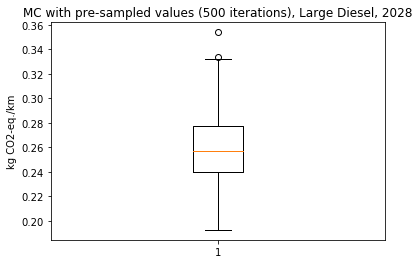

In [13]:
import matplotlib.pyplot as plt
plt.boxplot(results)
plt.title('MC with pre-sampled values (500 iterations), Large Diesel, 2028')
plt.ylabel("kg CO2-eq./km")
plt.show()